In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.dpi'] = 400


In [ ]:
# train_lc_dir =  '../data/test/npy/lc/test_lc_1_to_9.npy'
# train_lc_dir ='../data/vald/npy/lc/vald_lc_1_to_9.npy'
train_lc_dir ='../data/train/npy/lc/train_lc_1_to_9.npy'
train_lc = np.load(train_lc_dir)


In [ ]:
train_lc.shape

In [ ]:
# 2. Normalize the lightcurves
## - Train Set
train_lc_scaled = np.zeros(train_lc.shape)
for i in np.arange(len(train_lc_scaled)):
    train_lc_scaled[i] = (train_lc[i] - np.amin(train_lc[i]))/(np.amax(train_lc[i]) - np.amin(train_lc[i]))


In [ ]:
## - Train Set 
new_length_for_lc = 120
start_index = int((new_length_for_lc - 100)/2)
stop_index = start_index + 100
train_lc_scaled_append = np.ones((train_lc.shape[0],new_length_for_lc))
print('start_index = ',start_index)
print('stop_index = ',stop_index)
print('train_lc_scaled_append.shape = ',train_lc_scaled_append.shape)
print(f"len(train_lc_scaled_append[0,{start_index}:{stop_index}]) = ",len(train_lc_scaled_append[0,start_index:stop_index]))

for i in np.arange(len(train_lc_scaled)):
    train_lc_scaled_append[i,start_index:stop_index] = train_lc_scaled[i]

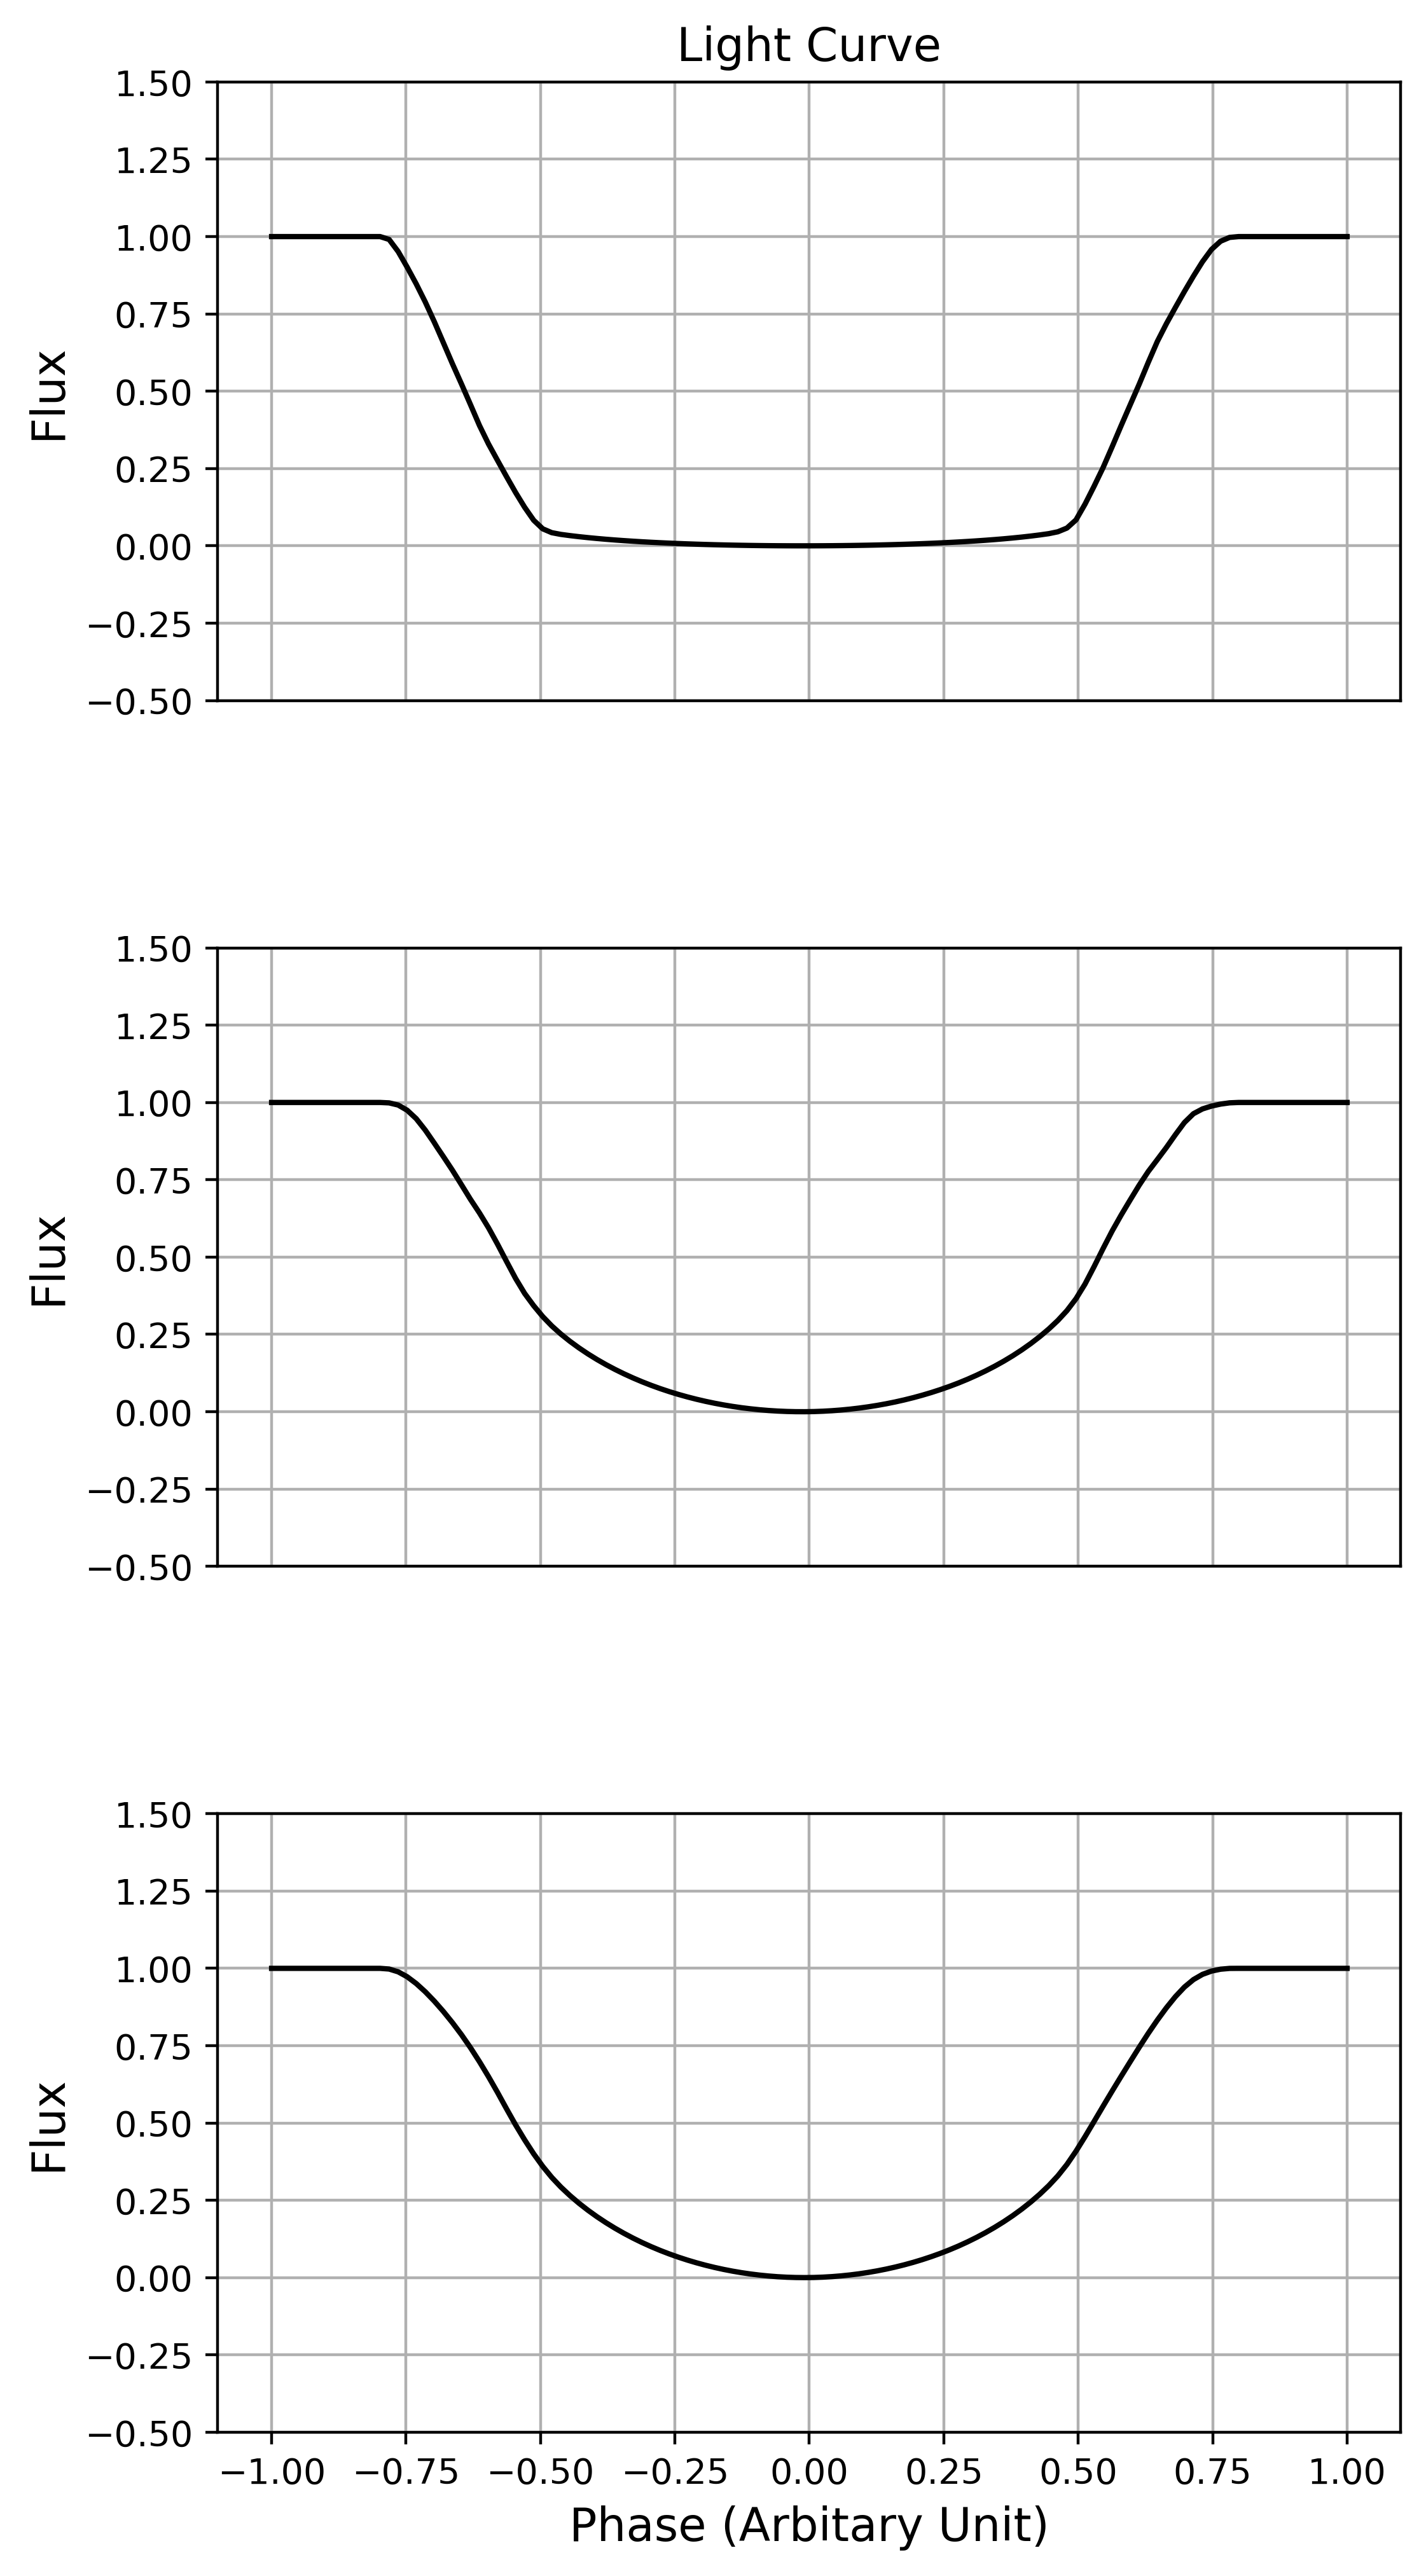

In [8]:
# Verification
# Plot - Train LCs
num = 3
fig,ax=plt.subplots(num,1, figsize=(6,12), gridspec_kw={ 'width_ratios': [1],
        'wspace': 0.4,'hspace': 0.4})
plt.rcParams['figure.dpi'] = 400

ax[0].set_title('Light Curve',size=13)
ax[num-1].set_xlabel('Phase (Arbitary Unit)',size=13)
ph_simul = np.linspace(-1,1,len(train_lc_scaled_append[0]))
# advance = 60

i = 0
for i in np.arange(0,num):
    k = np.random.randint(0, len(train_lc_scaled_append)-1)
    if(i<num-1): ax[i].tick_params(labelbottom = False, bottom = False)
    ax[i].set_ylabel('Flux',size=13)
    ax[i].set_ylim(-0.5,1.5)
    # ax[i][0].scatter(ph, vald_lc_scaled_append[k],color = 'black',marker='.')
    ax[i].plot(ph_simul, train_lc_scaled_append[k],color = 'black',linewidth='1.5')
    ax[i].grid('on')
    i = i + 1